In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np

from sky_spot import utils
from plot import *

sns.set_style('whitegrid')
InitMatplotlib(7, 7)
colors = sns.color_palette('colorblind', 10)

RESTART_OVERHEAD_HOURS = 0.2
TASK = 48
env_name = 'us-west-2b_v100_1'
# result_path = f'../../results/greedy-optimal/restart={RESTART_OVERHEAD_HOURS:.2f}/f_vs_gap_two_exp-180.csv'
result_path = f'../../results/real/ddl=search+task={TASK}+overhead={RESTART_OVERHEAD_HOURS:.2f}/{env_name}.csv'
result_path = f'../../results-plot/real/ddl=search+task={TASK}+overhead={RESTART_OVERHEAD_HOURS:.2f}/{env_name}.csv'

dfs = []
DDL = 52

origin_df = pd.read_csv(result_path)
origin_df['spot_fraction'] = origin_df['avg_spot_hours'] / (origin_df['avg_wait_hours'] +
                                                origin_df['avg_spot_hours'])
if 'deadline_hours' in origin_df.columns:
    origin_df['task_fraction'] = origin_df['task_duration_hours'] / origin_df['deadline_hours']
    DDL = max(origin_df['deadline_hours'])
else:    
    origin_df['task_fraction'] = origin_df['task_duration_hours'] / DDL
origin_df.drop_duplicates(inplace=True)
list(origin_df['strategy'].unique())

use_tex True 
font_size 7 
title_size 7


['strawman',
 'on_demand',
 'quick_optimal',
 'rc_v2dt_threshold',
 'rc_next_spot_threshold',
 'ideal_ilp_overhead',
 'rc_cr_threshold',
 'rc_1cr_threshold',
 'time_sliced_by_num']

In [25]:
origin_df['spot_fraction'].unique()

array([0.59517125])

In [44]:
def plot_cost_vs_n(ax, df, normalize_by_on_demand=True, cost_scale=1):
    optimal = df[df['strategy'] == 'quick_optimal']
    optimal_cost = None
    if len(optimal) != 0:
        optimal_cost = optimal['avg_cost'].values[0]
    time_sliced = df[df['strategy'] == 'time_sliced_by_num']
    # loose_time_sliced = df[df['strategy'] == 'loose_time_sliced_by_num']

    # on_demand_cost = (task_fraction * DDL + RESTART_OVERHEAD_HOURS) * utils.COSTS[utils.ClusterType.ON_DEMAND]
    on_demand = df[df['strategy'] == 'on_demand']
    on_demand_cost = on_demand['avg_cost'].values[0]
    actual_on_demand_cost = on_demand_cost * cost_scale
    if not normalize_by_on_demand:
        on_demand_cost = 1 / cost_scale

    greedy = df[df['strategy'] == 'strawman']
    assert len(greedy) == 1, greedy
    greedy_cost = greedy['avg_cost'].values[0]

    if 'rc_threshold' in df['strategy'].values:
        deficit = df[df['strategy'] == 'rc_threshold']
        deficit_cost = deficit['avg_cost'].values[0]
    if 'rc_vd_threshold' in df['strategy'].values:
        deficit_vd = df[df['strategy'] == 'rc_vd_threshold']
        deficit_vd_cost = deficit_vd['avg_cost'].values[0]
    if 'rc_vdt_threshold' in df['strategy'].values:
        deficit_v2dt = df[df['strategy'] == 'rc_v2dt_threshold']
        deficit_v2dt_cost = deficit_vd['avg_cost'].values[0]

    # loose_time_sliced[
    #     'avg_cost'] = loose_time_sliced['avg_cost'] / on_demand_cost
    time_sliced['avg_cost'] = 1 - time_sliced['avg_cost'] / on_demand_cost

    if 'std_cost' in df.columns:
        greedy['std_cost'] = greedy['std_cost'] / on_demand_cost
        time_sliced['std_cost'] = time_sliced['std_cost'] / on_demand_cost
        # loose_time_sliced['std_cost'] = loose_time_sliced['std_cost'] / on_demand_cost

    if not normalize_by_on_demand:
        sns.lineplot(x=list(range(1, DDL + 1)),
                     y=[actual_on_demand_cost] * DDL,
                    label='on demand',
                    ax=ax,
                    linestyle='--',
                    color=colors[0])

    all_x = list(range(1, DDL + 1, 8))
    if optimal_cost is not None:
        if 'std_cost' in df.columns:
            ax.fill_between(all_x,
                        [1 - optimal_cost / on_demand_cost - optimal['std_cost'].values[0] / on_demand_cost] * len(all_x),
                        [1 - optimal_cost / on_demand_cost + optimal['std_cost'].values[0] / on_demand_cost] * len(all_x),
                        label=None,
                        alpha=0.2,
                        color=colors[2])

        sns.lineplot(x=list(range(1, DDL + 1)),
                        y=[1 - optimal_cost / on_demand_cost] * DDL,
                        label='Optimal',
                        ax=ax,
                        linestyle='--',
                        color=colors[2])

    if 'std_cost' in df.columns:
        print('greedy std', greedy['std_cost'].values[0])
        ax.fill_between(all_x, [1 - greedy_cost / on_demand_cost - greedy['std_cost'].values[0]] * len(all_x), [1 - greedy_cost / on_demand_cost + greedy['std_cost'].values[0]] * len(all_x),
                    label=None, color=colors[0], alpha=0.2)
    sns.lineplot(x=list(range(1, DDL + 1)),
                    y=[1 - greedy_cost / on_demand_cost] * DDL,
                    label='Greedy',
                    ax=ax,
                    linestyle='--',
                    color=colors[0])

    if 'std_cost' in df.columns:
        time_sliced.sort_values(by='num_slices', inplace=True)
        ax.fill_between(time_sliced['num_slices'], time_sliced['avg_cost'] - time_sliced['std_cost'], time_sliced['avg_cost'] + time_sliced['std_cost'], label=None, color=colors[3], alpha=0.2)
    sns.lineplot(x=time_sliced['num_slices'],
                    y=time_sliced['avg_cost'],
                    label='Time Sliced',
                    ax=ax,
                    color=colors[3])
    # sns.lineplot(x=loose_time_sliced['num_slices'],
    #              y=loose_time_sliced['avg_cost'],
    #              label='loose sliced',
    #              ax=ax,
    #             color=colors[4])
    # if 'rc_threshold' in df['strategy'].values:
    #     sns.lineplot(x=list(range(1, DDL + 1)),
    #                  y=[deficit_cost / on_demand_cost] * DDL,
    #                  label='deficit limited',
    #                  ax=ax,
    #                  linestyle='-',
    #                  color=colors[4])
    # if 'rc_v2dt_threshold' in df['strategy'].values:
    #     sns.lineplot(x=list(range(1, DDL + 1)),
    #                  y=[deficit_v2dt_cost / on_demand_cost] * DDL,
    #                  label='deficit limited (V2DT)',
    #                  ax=ax,
    #                  linestyle='-',
    #                  color=colors[5])
    ax.set_xlabel('Number of Slices')
    ax.set_ylabel('Cost savings (\%)')
    ax.legend().set_visible(False)
    return ax

[0.5217391304347826, 0.5454545454545454, 0.5714285714285714, 0.6, 0.631578947368421, 0.6666666666666666, 0.7058823529411765, 0.75, 0.8, 0.8571428571428571, 0.9230769230769231]
[0.8, 0.63]
10.0
greedy std 0.16335999149222966
4.0
greedy std 0.21728467776456373


/tmp/ipykernel_2222/3687586672.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_sliced['avg_cost'] = 1 - time_sliced['avg_cost'] / on_demand_cost
/tmp/ipykernel_2222/3687586672.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greedy['std_cost'] = greedy['std_cost'] / on_demand_cost
/tmp/ipykernel_2222/3687586672.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

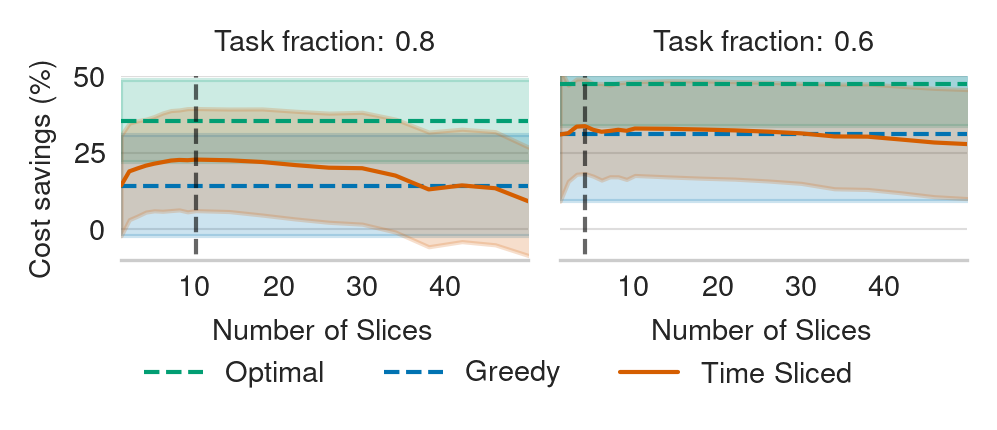

In [65]:
# env_name = 'two_exp'
# env_df = origin_df[np.isclose(origin_df['spot_fraction'], 0.6923076923076923)]
env_df = origin_df
# skip = 2
task_fractions = sorted(env_df[env_df['strategy'] == 'strawman']['task_fraction'].unique())
print(task_fractions)
task_fractions = [0.63, 0.71, 0.80, 0.92]
task_fractions = [0.80, 0.63]
print(task_fractions)
fig = plt.figure(figsize=(fig_width, fig_height - .8), dpi=300)
# axes = fig.subplots((len(task_fractions) + 1) // 2, 2, sharex=True)
axes = fig.subplots(1, 2, sharex=True, sharey=True)
for i, task_fraction in enumerate(task_fractions):
    # ax = axes[i // 2, i % 2]
    ax = axes[i]
    df = env_df[abs(env_df['task_fraction'] - task_fraction) < 0.01]
    best_num_slices = df.loc[df[df['strategy'] == 'time_sliced_by_num']['avg_cost'].idxmin(), 'num_slices']
    print(best_num_slices)
    # print(df['strategy'].unique())
    ax = plot_cost_vs_n(ax, df)
    ax.vlines(best_num_slices, -1, 1, colors='k', linestyles='--', label='', alpha=0.6)
    ax.set_title(f'Task fraction: {task_fraction:.1f}')
    ax.set_xlim(1, 50)
    ax.set_xticks([10, 20, 30, 40])
    ax.set_yticks([0.0, 0.25, 0.5])
    ax.set_yticklabels(['0', '25', '50'])
    ax.set_ylim(-0.1, 0.5)

# handler_ax = axes[0, 0]
handler_ax = axes[0]
fig.legend(title='',
           loc='lower center',
           ncol=5,
           handles=handler_ax.get_legend_handles_labels()[0],
           bbox_to_anchor=(0.5, -0.1))
# fig.suptitle(
#     # f'Cost with different number slices {env_name}'
#     # f'\n(spot_fraction={df["spot_fraction"].values[0]:.2f}, d={RESTART_OVERHEAD_HOURS:.2f}h, task={TASK}h)'
# )
fig.tight_layout()
fig.savefig('figures/cost_vs_n.pdf', bbox_inches='tight')

In [46]:
raise
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np

from sky_spot import utils
from plot import *

sns.set_style('whitegrid')
InitMatplotlib(7, 7)
colors = sns.color_palette('colorblind', n_colors=10)


RESTART_OVERHEAD_HOURS = 0.3
TASK = 48
# result_path = f'../../results/greedy-optimal/restart={RESTART_OVERHEAD_HOURS:.2f}/f_vs_gap_two_exp-180.csv'
result_dir = f'../../results/real/ddl=search+task={TASK}+overhead={RESTART_OVERHEAD_HOURS:.2f}'

dfs = []
DDL = 70

df = pd.DataFrame()
for file in os.listdir(result_dir):
    if not file.endswith('.csv'):
        continue
    result_path = os.path.join(result_dir, file)
    origin_df = pd.read_csv(result_path)
    origin_df['spot_fraction'] = origin_df['avg_spot_hours'] / (
        origin_df['avg_wait_hours'] + origin_df['avg_spot_hours'])
    if 'deadline_hours' in origin_df.columns:
        origin_df['task_fraction'] = origin_df['task_duration_hours'] / origin_df[
            'deadline_hours']
        DDL = max(origin_df['deadline_hours'])
    else:
        origin_df['task_fraction'] = origin_df['task_duration_hours'] / DDL
    origin_df.drop_duplicates(inplace=True)
    origin_df['env'] = file.replace('.csv', '')
    df = df.append(origin_df)

df = df.sort_values(by=['spot_fraction'], ascending=False)
df = df[df['deadline_hours'] == DDL]
env_paths = df['env'].unique()
fig = plt.figure(figsize=(fig_width, fig_width / golden_mean), dpi=300)
axes = fig.subplots((len(env_paths) + 1) // 2, 2, sharex=True)

for i, env_name in enumerate(env_paths):
    ax = axes[i // 2, i % 2]
    env_df = df[df['env'] == env_name]
    for cost_scale in utils.COST_SCALES:
        if cost_scale in env_name:
            break
    else:
        raise
    ax = plot_cost_vs_n(ax, env_df, normalize_by_on_demand=False, cost_scale=utils.COST_SCALES[cost_scale])
    ax.set_title(env_name)
    ax.set_xlim(1, 8)

    

fig.tight_layout()

RuntimeError: No active exception to reraise

In [ ]:
raise
from sky_spot import utils
env_name = 'two_exp'
env_df = origin_df[np.isclose(origin_df['spot_fraction'], 0.48387097)]
skip = 2
task_fractions = sorted(env_df['task_fraction'].unique())[8:-8:skip]
task_fractions = task_fractions[0:1] + task_fractions[3:]
print(task_fractions)
fig = plt.figure(figsize=(8, 12))
axes = fig.subplots(len(task_fractions) // 2, 2, sharex=True, sharey=True)
for i, task_fraction in enumerate(task_fractions):
    ax = axes[i // 2, i % 2]
    df = env_df[np.isclose(env_df['task_fraction'], task_fraction)]
    optimal = df[df['strategy'] == 'ideal_ilp_overhead']
    optimal_cost = optimal['avg_cost'].values[0]
    time_sliced = df[df['strategy'] == 'time_sliced_by_num']
    loose_time_sliced = df[df['strategy'] == 'loose_time_sliced_by_num']

    on_demand_cost = (task_fraction * DDL + RESTART_OVERHEAD_HOURS) * utils.COSTS[utils.ClusterType.ON_DEMAND]

    greedy = df[df['strategy'] == 'strawman']
    greedy_cost = greedy['avg_cost'].values[0]

    time_sliced['avg_cost'] = time_sliced['avg_cost'] / on_demand_cost
    loose_time_sliced[
        'avg_cost'] = loose_time_sliced['avg_cost'] / on_demand_cost

    sns.lineplot(x=list(range(1, 53)),
                 y=[optimal_cost / on_demand_cost] * 52,
                 label='optimal',
                 ax=ax)
    sns.lineplot(x=list(range(1, 53)),
                 y=[greedy_cost / on_demand_cost] * 52,
                 label='greedy',
                 ax=ax,
                 linestyle='--')
    sns.lineplot(x=time_sliced['num_slices'],
                 y=time_sliced['avg_cost'],
                 label='time_sliced',
                 ax=ax)
    sns.lineplot(x=loose_time_sliced['num_slices'],
                 y=loose_time_sliced['avg_cost'],
                 label='loose_time_sliced',
                 ax=ax)
    ax.set_title(f'task_fraction={task_fraction:.2f}')
    ax.set_xlabel('#slices')
    ax.set_ylabel('Cost ratio')
    ax.legend().set_visible(False)
    ax.set_ylim(0.3, 1.1)

handler_ax = axes[0, 0]
fig.legend(title='Strategy',
           loc='lower center',
           ncol=5,
           handles=handler_ax.get_legend_handles_labels()[0],
           bbox_to_anchor=(0.5, -0.04))
fig.suptitle(
    f'Cost ratio against on-demand on {env_name}\n(spot_fraction={df["spot_fraction"].values[0]:.2f}, d={RESTART_OVERHEAD_HOURS:.2f}h)'
)
fig.tight_layout()

RuntimeError: No active exception to reraise